In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
from tqdm.notebook import tqdm

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.utils import update_config

[Fri, 20 Oct 2023 14:02:26] [INFO    ] [topostats] Extracting image from C:\Users\obataya\GitHub-repo\line_detection\data\polymer.gwy
[Fri, 20 Oct 2023 14:02:26] [INFO    ] [topostats] Loading image from : C:\Users\obataya\GitHub-repo\line_detection\data\polymer.gwy
[Fri, 20 Oct 2023 14:02:26] [INFO    ] [topostats] 	(polymer) has a topography image with z-height data(m).
[Fri, 20 Oct 2023 14:02:26] [INFO    ] [topostats] [polymer] Image added to processing.
Shape of image data: (320, 240)
Available keys: dict_keys(['filename', 'channel', 'img_path', 'pixel_to_nm_scaling', 'image_original', 'image_flattened', 'grain_masks', 'scale'])


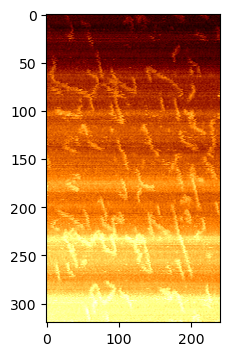

In [2]:
# Set BASE_DIR containing a file and config.yaml
BASE_DIR=Path(os.getenv('REPO')).joinpath('line_detection').joinpath('data')
FILE_EXT = ".gwy"
IMG_FILES = [BASE_DIR.joinpath('polymer.gwy'),]
IMG_KEY = "polymer"

config = read_yaml(BASE_DIR.joinpath("polymer_config.yaml"))
#print(json.dumps(config, indent=4)) # print json dump
loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
loaded_data = LoadScans(IMG_FILES, **config["loading"])
loaded_data.get_data()

print(f"Shape of image data: {np.shape(loaded_data.image)}")
print(f"Available keys: {loaded_data.img_dict[IMG_KEY].keys()}")
# Plot the loaded scan in its raw format
fig, ax = plt.subplots(figsize=(4, 4))
# When Topostats loads .gwy file, aspect ratio of the image is in img_dict.
plt.imshow(loaded_data.image, cmap="afmhot", aspect=loaded_data.img_dict[IMG_KEY]["scale"]["xy_aspect"])
plt.show()

In [3]:
# Filter
filtered_image = Filters(
        image=loaded_data.img_dict[IMG_KEY]["image_original"],
        filename=loaded_data.img_dict[IMG_KEY]["img_path"],
        pixel_to_nm_scaling=loaded_data.img_dict[IMG_KEY]["pixel_to_nm_scaling"],
        **filter_config,)
filtered_image.filter_image()

[Fri, 20 Oct 2023 14:02:29] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Median flattening without mask
[Fri, 20 Oct 2023 14:02:29] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Plane tilt removal without mask
[Fri, 20 Oct 2023 14:02:29] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : x-polyfit 1st order: [-0.00066365  0.07657334]
[Fri, 20 Oct 2023 14:02:29] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : y-polyfit 1st order: [ 1.15611775e-17 -2.24368810e-15]
[Fri, 20 Oct 2023 14:02:29] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Removing x plane tilt
[Fri, 20 Oct 2023 14:02:29] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : removing y plane tilt
[Fri, 20 Oct 2023 14:02:29] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Remove 

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered', 'initial_nonlinear_polynomial_removal', 'masked_nonlinear_polynomial_removal'])


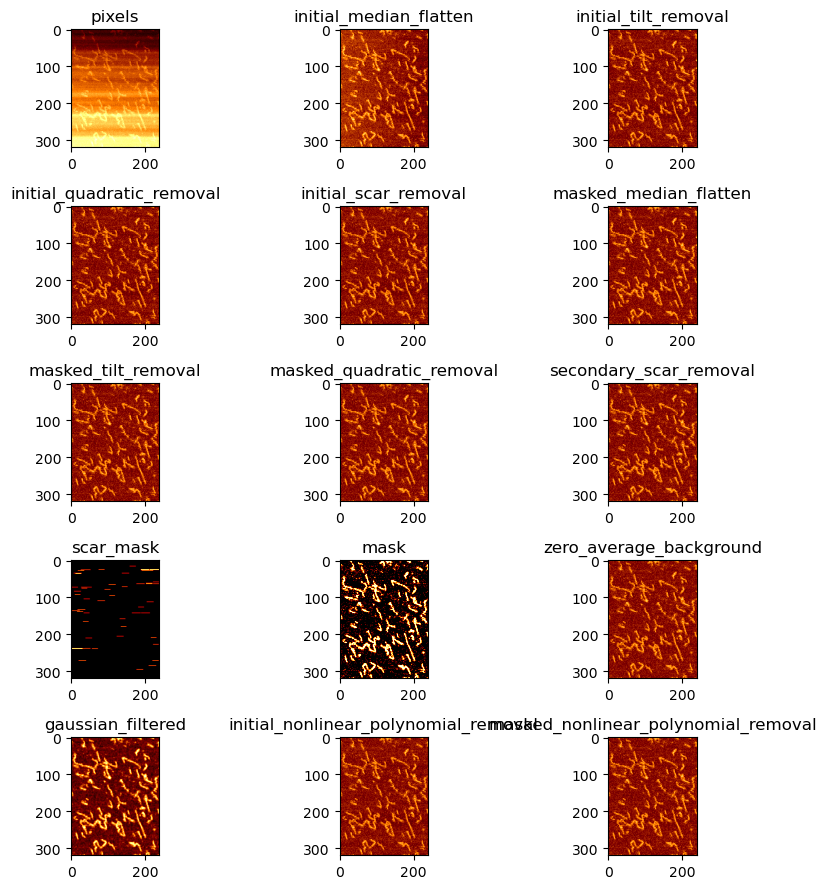

In [4]:
# image tiler
def tile_all_images(image_dict, cols):
    key_list = list(image_dict.keys())
    key_count = len(key_list)
    
    rows = int((key_count - key_count % cols) / cols)

    fig, ax = plt.subplots(rows,cols,figsize=(9,9))
    idx = 0
    for row in range(rows):
        for col in range(cols):
            key = key_list[idx]
            if image_dict[key] is None:
                continue
            ax[row,col].set_title(key)
            ax[row,col].imshow(image_dict[key], cmap="afmhot")
            idx += 1
            if idx == key_count:
                break
        if idx == key_count:
            break
    fig.tight_layout()
    plt.show()

SHOW_TILE = True
if SHOW_TILE:
    print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")
    tile_all_images(filtered_image.images,3)

# Find grains

Here polymer chains are detected by using Grains of Topostats. Resulting Numpy array of "labelled_regions_02" conatins index label starting with 1 for all polymer chains. 

In [6]:
labelled = grains.directions["above"]["labelled_regions_02"]
grains = Grains(
                image=filtered_image.images["zero_average_background"],
                filename=filtered_image.filename,
                pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
                **grain_config,
                )
grains.find_grains()

print(f"Resulting image keys above threshold:\n {grains.directions['above'].keys()}")
print(f"Resuting labelled image of polymer chains:\n count {labelled.max()}, type {type(labelled)}, shape {labelled.shape}")

[Fri, 20 Oct 2023 14:03:23] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Thresholding method (grains) : otsu
[Fri, 20 Oct 2023 14:03:23] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Finding above grains, threshold: (0.18092139420524733)
[Fri, 20 Oct 2023 14:03:23] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Masking (above) Threshold: 0.18092139420524733
[Fri, 20 Oct 2023 14:03:23] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Labelling Regions
[Fri, 20 Oct 2023 14:03:23] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Tidying borders
[Fri, 20 Oct 2023 14:03:23] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Removing noise (above)
[Fri, 20 Oct 2023 14:03:23] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Area thresholding gra

# Line detection
Linemol module is for detection of linear part of polymer chain of SPM height data. Principle of this analysis is to score all possible lines in a molecule. The score is calculated from the sum of the height values of the pixels that make up the line.

## Data import and filtering by Topostats
Topostats is a Python library for topological data analysis. It provides a set of tools for analyzing and visualizing topological data, such as persistent homology, persistent diagrams, and other related techniques. It is designed to be easy to use and extend, and is suitable for both research and educational purposes. Filtering and finding grains from a Gwyddion file are conducted by Topostats software program. 

## Molecule class
Pixels of each molecule are obtained from grains.directions["above"]["labelled_regions_02"]. A class of `LineDetection` handles the labelled regions ndarray. All molecules are stored as `Molecule` object that provide positions, vectors generated from the positions, methods for detection of linear part.

## Processing
Number of all possible vectors in a molecule sometimes comes enormous, so several steps are implemented to reduce unnecessary lines.

### Qudrants and length filtering
vector pairs are filtered by direction and length. The minimum and maximum length are defined as `min_len` and `max_len` in a config dict.
-  Exclude vectors from the set that are facing the third and fourth quadrants.
-  Exclude vectors exceeding provided minimum and maximum length

### Empty pixel(s) along a line
After collecting the set of vectors, a synthetic straight line is drawn in 2D binary array. When original binary data has gaps along the synthetic line, it is considered to have 'empty' pixels. A line with large number of empty pixels are excluded because it should not be regard as a straight and continuous line. The maximum pixel number is defined as `allowed_empty` in a config dict.

Resulting lines are stored as DataFrame of pandas. Initial dataframe has columns of `mol_idx`, `score`, `pix1`, `pix2`, `angle`, `overlapped`.

### Overlapping lines
Some lines are covered with a longer line completely, others are covered partially. Shorter and lines with lower score that is covered with other line can be eliminated. In order to prioritize score, dataframe was sorted descending by `score` column.



In [73]:
# assuming linedetection.py is in parent directory of data 
#MOD_DIR=Path(os.getenv('REPO')).joinpath('line_detection')
#sys.path.append(MOD_DIR)
import linemol
importlib.reload(linemol)
from linemol import Molecule, LineDetection

In [126]:
labelled = grains.directions["above"]["labelled_regions_02"]
source = filtered_image.images["gaussian_filtered"]
config = {"min_len":10, "max_len":40,"allowed_empty":1}

ld = LineDetection(labelled, source, **config)

[]

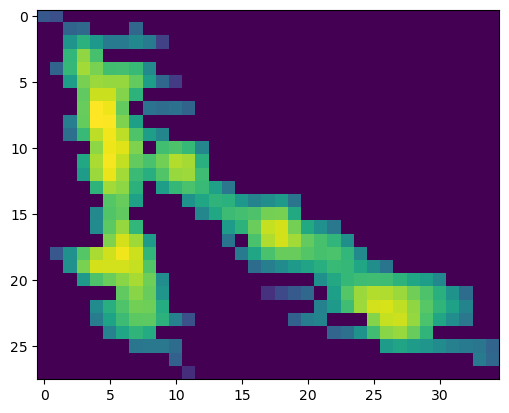

In [127]:
idx = 42
mol = ld.molecules[idx]
mol_image = mol.get_source_image()
plt.imshow(mol_image)
plt.plot()

In [128]:
filtered_vecs = ld.filter_by_length(mol)
count = ld.score_lines(mol, filtered_vecs, record_neg_empty=False)

# Normalized score

This normalization should be conducted for each molecule.

In [129]:
mol7 = ld.score_df.loc[ld.score_df["mol_idx"]==7]
mol42 = ld.score_df.loc[ld.score_df["mol_idx"]==43]

In [175]:
mol_score.sort_values("angle",ascending=False)

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
7176,43,3.141449,1,30,20,17,21,13.038405,175.601295,-1.278281
7393,43,2.920738,1,29,20,17,21,12.041595,175.236358,-1.405962
7161,43,3.149963,1,30,20,18,21,12.041595,175.236358,-1.273355
7434,43,2.852350,1,29,20,18,21,11.045361,174.805571,-1.445525
7544,43,2.624329,1,28,20,17,21,11.045361,174.805571,-1.577435
...,...,...,...,...,...,...,...,...,...,...
6008,43,3.842971,0,21,22,31,22,10.000000,0.000000,-0.872448
6541,43,3.570761,1,19,21,30,21,11.000000,0.000000,-1.029923
6065,43,3.815127,1,19,21,31,21,12.000000,0.000000,-0.888556
6873,43,3.374601,1,18,21,29,21,11.000000,0.000000,-1.143402


In [208]:
def plot_emphasized_by_score(ld, mol, ilocs):
    """ Plot an emphasized line in src image"""
    mol_score = ld.score_df.loc[ld.score_df["mol_idx"]==mol.mol_idx]
    if len(mol_score)==0:
        return
    line_mask = mol.get_blank()
    for iloc in ilocs:
        row = mol_score.iloc[iloc].tolist()
        (x1,y1,x2,y2) = tuple(row[3:7])
        line_mask = line_mask + (ld.draw_line(x1,y1,x2,y2,mol.height,mol.width))
    line_mask = line_mask / (len(ilocs))
    emp = ld.get_emphasized(mol,line_mask,factor=4)
    plt.imshow(emp)
    plt.plot()


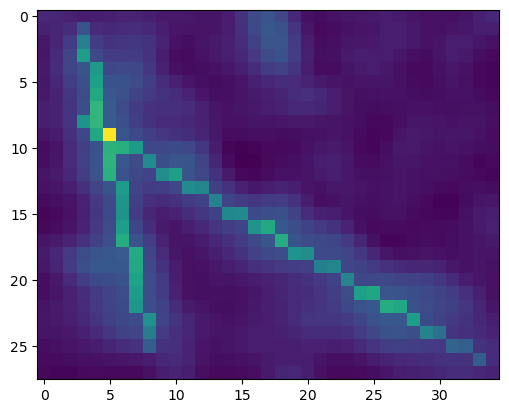

In [209]:
plot_emphasized_by_score(ld,mol,[0,66])

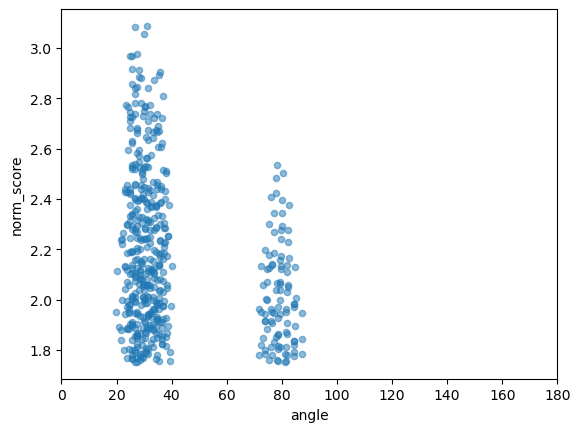

In [214]:
ret = mol42[0:500].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))


In [211]:
type(ret)

matplotlib.axes._subplots.AxesSubplot

<AxesSubplot:ylabel='Frequency'>

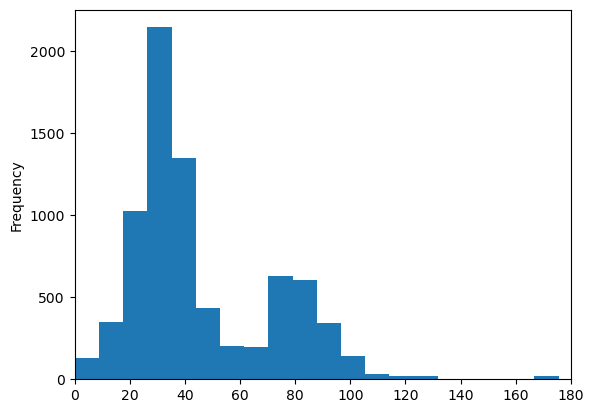

In [215]:
mol42["angle"].plot.hist(bins=20, xlim=(0,180))

In [114]:
for i in range(0,len(ld.molecules)):
    mol = ld.molecules[i]
    filtered = ld.filter_by_length(mol)
    print(f"{i} ({mol.mol_idx})\t\t{mol.count()} pixels\t\t{len(filtered)} vectors")

# 53 : 393 pixel -> filter length + line detection : 10sec

0 (1)		109 pixels		1424 vectors
1 (2)		43 pixels		92 vectors
2 (3)		109 pixels		1501 vectors
3 (4)		24 pixels		0 vectors
4 (5)		68 pixels		386 vectors
5 (6)		84 pixels		908 vectors
6 (7)		111 pixels		1440 vectors
7 (8)		97 pixels		1786 vectors
8 (9)		1230 pixels		305050 vectors
9 (10)		101 pixels		1801 vectors
10 (11)		113 pixels		1529 vectors
11 (12)		39 pixels		0 vectors
12 (13)		149 pixels		6424 vectors
13 (14)		105 pixels		1490 vectors
14 (15)		61 pixels		267 vectors
15 (16)		102 pixels		2012 vectors
16 (17)		58 pixels		205 vectors
17 (18)		225 pixels		15839 vectors
18 (19)		252 pixels		17858 vectors
19 (20)		108 pixels		1750 vectors
20 (21)		119 pixels		1535 vectors
21 (22)		187 pixels		10414 vectors
22 (23)		149 pixels		5855 vectors
23 (24)		118 pixels		2567 vectors
24 (25)		87 pixels		1015 vectors
25 (26)		122 pixels		3745 vectors
26 (27)		61 pixels		358 vectors
27 (28)		144 pixels		4482 vectors
28 (29)		145 pixels		4443 vectors
29 (30)		289 pixels		27153 vectors
30 (31)		31 pix

[]

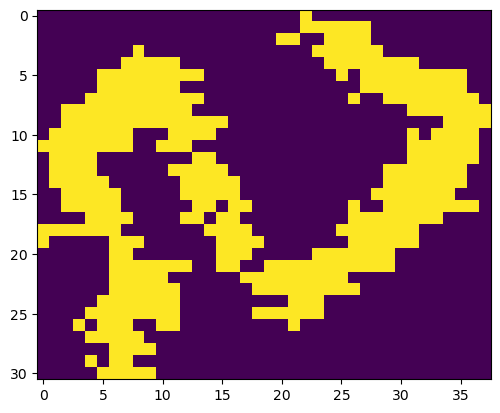

In [110]:
plt.imshow(ld.molecules[53].get_mask())
plt.plot()

77028.0